# 🔥 BiLSTM Model Training: Emotion Classification

This notebook trains a Bidirectional LSTM model on preprocessed emotion data using **GloVe** pre-trained embeddings.

**Embedding Strategy:** GloVe (Twitter, 200d) - captures global co-occurrence statistics that complement LSTM's long-term dependency learning.


## 📚 Import Libraries


## 📦 Install Dependencies (Run on Colab)


In [10]:
# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Install dependencies only on Colab
if IN_COLAB:
    print("Running on Google Colab - Installing dependencies...")
    %pip install -q gensim==4.4.0 h5py==3.15.1 keras==3.12.0 matplotlib==3.10.6 nltk==3.9.2 numpy==2.2.5 pandas==2.3.3 scikit-learn==1.7.2 scipy==1.15.3 seaborn==0.13.2 tensorflow==2.20.0 wordcloud==1.9.4
    print("Dependencies installed successfully!")
else:
    print("Running locally - Using local dependencies")


Running locally - Using local dependencies


In [11]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import random
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 📂 Load Preprocessed Data


In [12]:
# Load preprocessed training and validation data
train_df = pd.read_pickle('./data/train_preprocessed.pkl')
val_df = pd.read_pickle('./data/validation_preprocessed.pkl')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())


Training data shape: (15999, 2)
Validation data shape: (2000, 2)

Columns: ['Text', 'Label']

First few rows:
                                                Text  Label
0                              didnt feel humiliated      0
1  go feeling hopeless damned hopeful around some...      0
2          im grabbing minute post feel greedy wrong      3
3  ever feeling nostalgic fireplace know still pr...      2
4                                    feeling grouchy      3


## 📊 Prepare Data

Split the data into features (X) and labels (y).


In [13]:
# Prepare X and y
X_train = train_df['Text']
y_train = train_df['Label']
X_val = val_df['Text']
y_val = val_df['Label']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts().sort_index())


Training samples: 15999
Validation samples: 2000

Label distribution in training set:
Label
0    4666
1    5361
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


## 🔠 Tokenization

Convert text to sequences of integers.


In [14]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Find maximum sequence length
maxlen = max(len(tokens) for tokens in X_train_sequences)
print(f"Maximum sequence length: {maxlen}")

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

print(f"\nX_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")

# Calculate input size for embedding layer
input_size = np.max(X_train_padded) + 1
print(f"Vocabulary size (input_size): {input_size}")


Maximum sequence length: 35

X_train_padded shape: (15999, 35)
X_val_padded shape: (2000, 35)
Vocabulary size (input_size): 15064


## 🌐 Prepare GloVe Embeddings

Using pre-trained **GloVe** embeddings for the LSTM model. GloVe captures global co-occurrence statistics, which complements LSTM's ability to learn long-term dependencies.


In [15]:
# Download and prepare GloVe embeddings
import gensim.downloader as api

print("📥 Downloading GloVe pre-trained embeddings (Twitter 200d)...")
print("This may take a few minutes on first run...")

# Download pre-trained GloVe model (Twitter, 200 dimensions)
# Using Twitter GloVe as it's trained on social media text (similar to emotions dataset)
glove_model = api.load('glove-twitter-200')

print("✅ GloVe embeddings loaded successfully!")

# Embedding dimension
embedding_dim = 200

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with GloVe vectors
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError:
        # Word not in GloVe vocabulary, leave as zeros
        misses += 1

print(f"\n📊 Embedding Matrix Statistics:")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Words found in GloVe: {hits}")
print(f"   Words not found (using zeros): {misses}")
print(f"   Coverage: {100 * hits / (hits + misses):.2f}%")


📥 Downloading GloVe pre-trained embeddings (Twitter 200d)...
This may take a few minutes on first run...
✅ GloVe embeddings loaded successfully!

📊 Embedding Matrix Statistics:
   Vocabulary size: 15064
   Embedding dimension: 200
   Words found in GloVe: 14155
   Words not found (using zeros): 908
   Coverage: 93.97%


## 🔬 Hyperparameter Tuning Experiments

Now let's systematically test different hyperparameters to understand their impact on LSTM model performance.


In [16]:
# Function to create and train an LSTM model with custom hyperparameters
def train_lstm_model(lstm_units=128, dropout_rate=0.5, learning_rate=0.001, 
                      batch_size=32, dense_units=64, epochs=10, 
                      embedding_trainable=False, optimizer_name='adam'):
    """
    Train an LSTM model with specified hyperparameters and return validation results.
    """
    # Build model
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=embedding_trainable
    ))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    
    # Compile with specified optimizer and learning rate
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = 'adam'
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(
        X_train_padded, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0  # Suppress output for cleaner results
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
    
    return {
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'best_epoch': len(history.history['val_accuracy']),
        'history': history.history
    }

print("✅ Helper function defined")


✅ Helper function defined


### 🔍 Running All Hyperparameter Experiments

Testing: Learning Rate, Batch Size, LSTM Units, Dropout Rate, Optimizer, and Embedding Trainability


In [17]:
# Diagnostic: Check what's in the gensim cache
import gensim.downloader as api
import os

cache_dir = api.base_dir
print(f"📁 Gensim cache directory: {cache_dir}")
print()

# Check if cache directory exists
if os.path.exists(cache_dir):
    print("✅ Cache directory exists")
    
    # List what's in the cache
    contents = os.listdir(cache_dir)
    if contents:
        print(f"\n📦 Contents ({len(contents)} items):")
        for item in contents:
            item_path = os.path.join(cache_dir, item)
            if os.path.isfile(item_path):
                size_mb = os.path.getsize(item_path) / (1024 * 1024)
                print(f"   - {item} ({size_mb:.1f} MB)")
            else:
                print(f"   - {item}/ (directory)")
    else:
        print("\n📭 Cache is empty - no models downloaded yet")
else:
    print("❌ Cache directory doesn't exist yet")

# List available models
print("\n\n🌐 Available GloVe models to download:")
info = api.info()
glove_models = {k: v for k, v in info['models'].items() if 'glove' in k}
for model_name, model_info in glove_models.items():
    size_mb = model_info.get('file_size', 0) / (1024 * 1024)
    print(f"   - {model_name}: {size_mb:.0f} MB")


📁 Gensim cache directory: /home/ido/gensim-data

✅ Cache directory exists

📦 Contents (3 items):
   - information.json (0.0 MB)
   - word2vec-google-news-300/ (directory)
   - glove-twitter-200/ (directory)


🌐 Available GloVe models to download:
   - glove-wiki-gigaword-50: 66 MB
   - glove-wiki-gigaword-100: 128 MB
   - glove-wiki-gigaword-200: 252 MB
   - glove-wiki-gigaword-300: 376 MB
   - glove-twitter-25: 105 MB
   - glove-twitter-50: 200 MB
   - glove-twitter-100: 387 MB
   - glove-twitter-200: 759 MB


In [18]:
import tensorflow as tf

# Experiment 1: Learning Rate
print("=" * 80)
print("EXPERIMENT 1: Learning Rate")
print("=" * 80)

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
lr_results = []

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    result = train_lstm_model(learning_rate=lr, epochs=10)
    lr_results.append({
        'learning_rate': lr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

lr_df = pd.DataFrame(lr_results)

# Experiment 2: Batch Size
print("\n" + "=" * 80)
print("EXPERIMENT 2: Batch Size")
print("=" * 80)

batch_sizes = [16, 32, 64, 128]
batch_results = []

for bs in batch_sizes:
    print(f"Testing batch size: {bs}")
    result = train_lstm_model(batch_size=bs, epochs=10)
    batch_results.append({
        'batch_size': bs,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

batch_df = pd.DataFrame(batch_results)

# Experiment 3: LSTM Units
print("\n" + "=" * 80)
print("EXPERIMENT 3: LSTM Units")
print("=" * 80)

lstm_units_list = [64, 96, 128, 192, 256]
lstm_results = []

for units in lstm_units_list:
    print(f"Testing LSTM units: {units}")
    result = train_lstm_model(lstm_units=units, epochs=10)
    lstm_results.append({
        'lstm_units': units,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

lstm_df = pd.DataFrame(lstm_results)

# Experiment 4: Dropout Rate
print("\n" + "=" * 80)
print("EXPERIMENT 4: Dropout Rate")
print("=" * 80)

dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]
dropout_results = []

for dr in dropout_rates:
    print(f"Testing dropout rate: {dr}")
    result = train_lstm_model(dropout_rate=dr, epochs=10)
    dropout_results.append({
        'dropout_rate': dr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

dropout_df = pd.DataFrame(dropout_results)

# Experiment 5: Optimizer
print("\n" + "=" * 80)
print("EXPERIMENT 5: Optimizer")
print("=" * 80)

optimizers = ['adam', 'rmsprop', 'sgd']
opt_results = []

for opt in optimizers:
    print(f"Testing optimizer: {opt}")
    result = train_lstm_model(optimizer_name=opt, epochs=10)
    opt_results.append({
        'optimizer': opt,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

opt_df = pd.DataFrame(opt_results)

# Experiment 6: Embedding Trainability
print("\n" + "=" * 80)
print("EXPERIMENT 6: Embedding Trainability")
print("=" * 80)

emb_configs = [False, True]
emb_labels = ['Frozen', 'Fine-tuned']
emb_results = []

for trainable, label in zip(emb_configs, emb_labels):
    print(f"Testing: {label} embeddings")
    result = train_lstm_model(embedding_trainable=trainable, epochs=10)
    emb_results.append({
        'configuration': label,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}\n")

emb_df = pd.DataFrame(emb_results)

print("\n✅ All experiments completed!")


EXPERIMENT 1: Learning Rate
Testing learning rate: 0.0001
  Val Accuracy: 0.7825

Testing learning rate: 0.0005
  Val Accuracy: 0.9095

Testing learning rate: 0.001
  Val Accuracy: 0.9250

Testing learning rate: 0.005
  Val Accuracy: 0.9165

Testing learning rate: 0.01
  Val Accuracy: 0.8615


EXPERIMENT 2: Batch Size
Testing batch size: 16
  Val Accuracy: 0.9035

Testing batch size: 32
  Val Accuracy: 0.9165

Testing batch size: 64
  Val Accuracy: 0.9070

Testing batch size: 128
  Val Accuracy: 0.9040


EXPERIMENT 3: LSTM Units
Testing LSTM units: 64
  Val Accuracy: 0.9115

Testing LSTM units: 96
  Val Accuracy: 0.9140

Testing LSTM units: 128
  Val Accuracy: 0.9175

Testing LSTM units: 192
  Val Accuracy: 0.9195

Testing LSTM units: 256
  Val Accuracy: 0.9100


EXPERIMENT 4: Dropout Rate
Testing dropout rate: 0.2
  Val Accuracy: 0.9180

Testing dropout rate: 0.3
  Val Accuracy: 0.9245

Testing dropout rate: 0.4
  Val Accuracy: 0.9210

Testing dropout rate: 0.5
  Val Accuracy: 0.9030


### 📊 Comprehensive Hyperparameter Tuning Summary

Visualize and compare all hyperparameter experiment results.


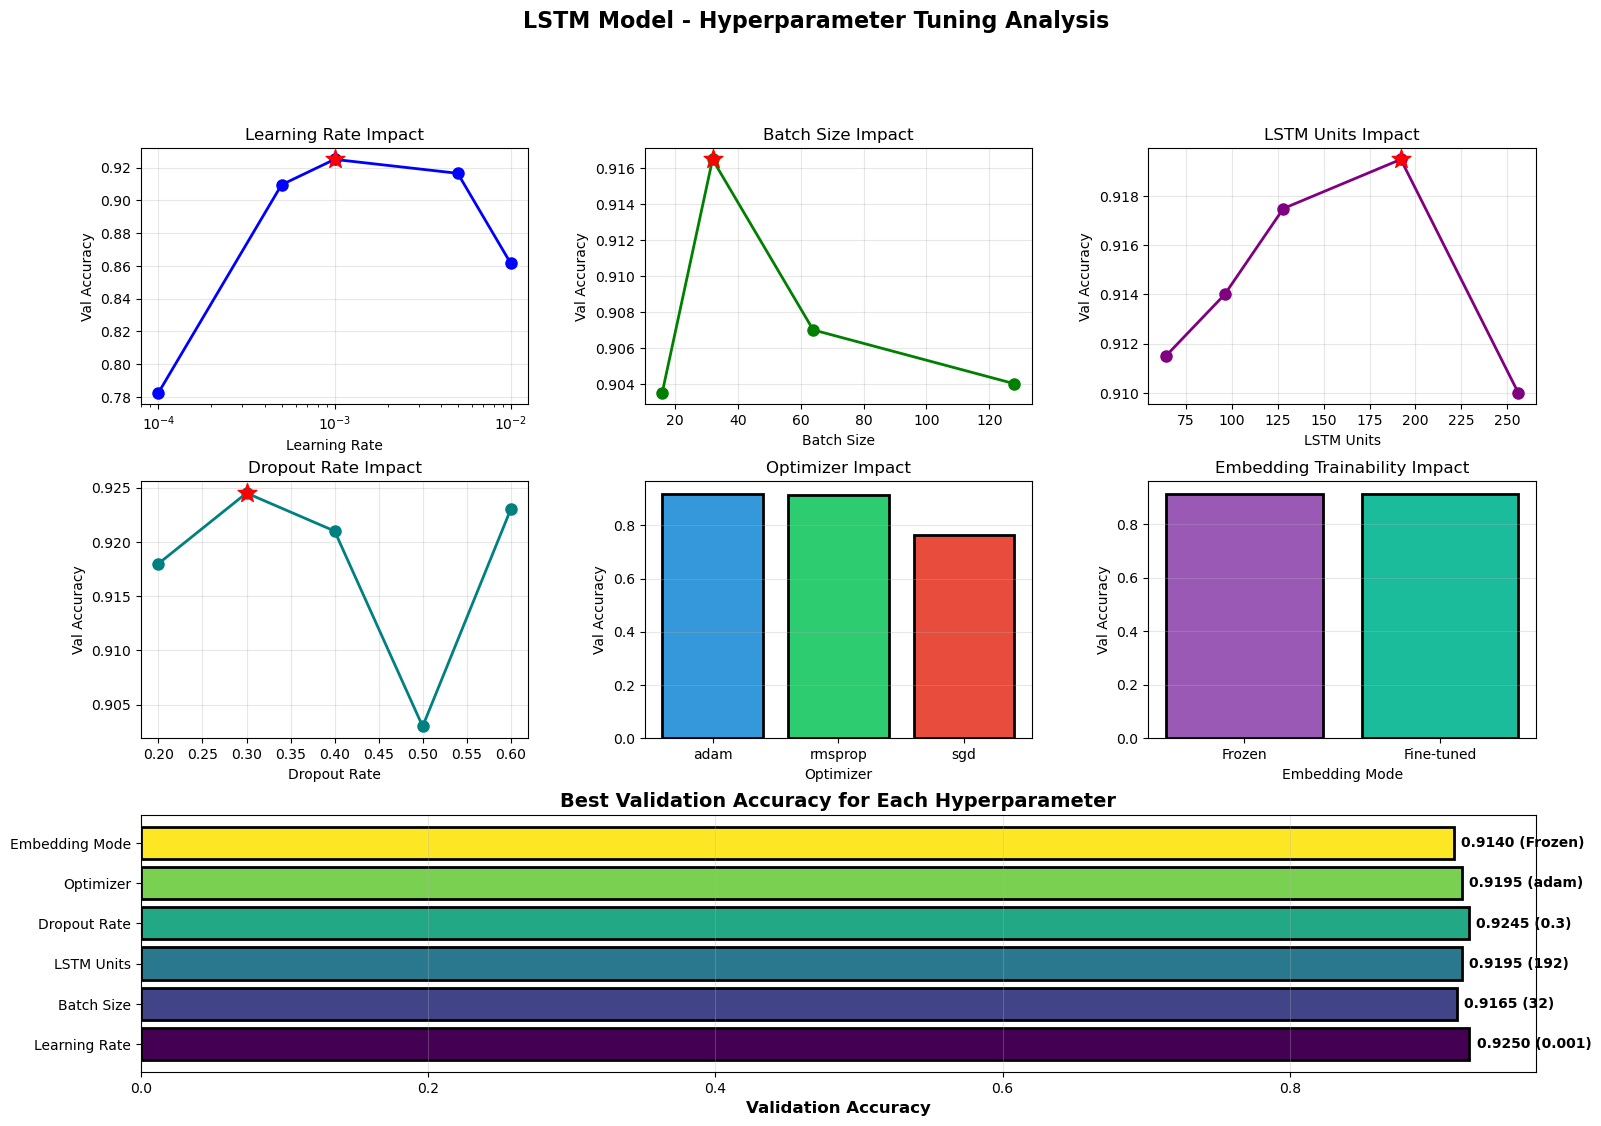


🏆 HYPERPARAMETER TUNING RESULTS SUMMARY - LSTM MODEL
Hyperparameter Best Value  Val Accuracy  Val Loss
 Learning Rate      0.001        0.9250  0.226078
    Batch Size         32        0.9165  0.218803
    LSTM Units        192        0.9195  0.209268
  Dropout Rate        0.3        0.9245  0.210494
     Optimizer       adam        0.9195  0.212061
Embedding Mode     Frozen        0.9140  0.200380

💡 RECOMMENDATIONS FOR OPTIMAL LSTM MODEL
Learning Rate        0.001
Batch Size           32
LSTM Units           192
Dropout Rate         0.3
Optimizer            adam
Embedding Mode       Frozen

🎯 Expected Validation Accuracy: 0.9250
📉 Expected Validation Loss:     0.2004


In [19]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Learning Rate
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lr_df['learning_rate'], lr_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Val Accuracy')
ax1.set_title('Learning Rate Impact')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
best_lr_idx = lr_df['val_accuracy'].idxmax()
ax1.scatter(lr_df.loc[best_lr_idx, 'learning_rate'], lr_df.loc[best_lr_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 2: Batch Size
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(batch_df['batch_size'], batch_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Val Accuracy')
ax2.set_title('Batch Size Impact')
ax2.grid(True, alpha=0.3)
best_batch_idx = batch_df['val_accuracy'].idxmax()
ax2.scatter(batch_df.loc[best_batch_idx, 'batch_size'], batch_df.loc[best_batch_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 3: LSTM Units
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(lstm_df['lstm_units'], lstm_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='purple')
ax3.set_xlabel('LSTM Units')
ax3.set_ylabel('Val Accuracy')
ax3.set_title('LSTM Units Impact')
ax3.grid(True, alpha=0.3)
best_lstm_idx = lstm_df['val_accuracy'].idxmax()
ax3.scatter(lstm_df.loc[best_lstm_idx, 'lstm_units'], lstm_df.loc[best_lstm_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 4: Dropout Rate
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(dropout_df['dropout_rate'], dropout_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='teal')
ax4.set_xlabel('Dropout Rate')
ax4.set_ylabel('Val Accuracy')
ax4.set_title('Dropout Rate Impact')
ax4.grid(True, alpha=0.3)
best_dropout_idx = dropout_df['val_accuracy'].idxmax()
ax4.scatter(dropout_df.loc[best_dropout_idx, 'dropout_rate'], dropout_df.loc[best_dropout_idx, 'val_accuracy'], 
           color='red', s=200, marker='*', zorder=5)

# Plot 5: Optimizer
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(opt_df['optimizer'], opt_df['val_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
ax5.set_xlabel('Optimizer')
ax5.set_ylabel('Val Accuracy')
ax5.set_title('Optimizer Impact')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Embedding Trainability
ax6 = fig.add_subplot(gs[1, 2])
ax6.bar(emb_df['configuration'], emb_df['val_accuracy'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
ax6.set_xlabel('Embedding Mode')
ax6.set_ylabel('Val Accuracy')
ax6.set_title('Embedding Trainability Impact')
ax6.grid(True, alpha=0.3, axis='y')

# Create summary data
summary_data = []
summary_data.append({
    'Hyperparameter': 'Learning Rate',
    'Best Value': f"{lr_df.loc[lr_df['val_accuracy'].idxmax(), 'learning_rate']}",
    'Val Accuracy': lr_df['val_accuracy'].max(),
    'Val Loss': lr_df.loc[lr_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Batch Size',
    'Best Value': f"{int(batch_df.loc[batch_df['val_accuracy'].idxmax(), 'batch_size'])}",
    'Val Accuracy': batch_df['val_accuracy'].max(),
    'Val Loss': batch_df.loc[batch_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'LSTM Units',
    'Best Value': f"{int(lstm_df.loc[lstm_df['val_accuracy'].idxmax(), 'lstm_units'])}",
    'Val Accuracy': lstm_df['val_accuracy'].max(),
    'Val Loss': lstm_df.loc[lstm_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Dropout Rate',
    'Best Value': f"{dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'dropout_rate']}",
    'Val Accuracy': dropout_df['val_accuracy'].max(),
    'Val Loss': dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Optimizer',
    'Best Value': opt_df.loc[opt_df['val_accuracy'].idxmax(), 'optimizer'],
    'Val Accuracy': opt_df['val_accuracy'].max(),
    'Val Loss': opt_df.loc[opt_df['val_accuracy'].idxmax(), 'val_loss']
})
summary_data.append({
    'Hyperparameter': 'Embedding Mode',
    'Best Value': emb_df.loc[emb_df['val_accuracy'].idxmax(), 'configuration'],
    'Val Accuracy': emb_df['val_accuracy'].max(),
    'Val Loss': emb_df.loc[emb_df['val_accuracy'].idxmax(), 'val_loss']
})

summary_df = pd.DataFrame(summary_data)

# Plot 7: Summary Bar Chart (spanning bottom row)
ax7 = fig.add_subplot(gs[2, :])
colors = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
bars = ax7.barh(summary_df['Hyperparameter'], summary_df['Val Accuracy'], color=colors, edgecolor='black', linewidth=2)
ax7.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax7.set_title('Best Validation Accuracy for Each Hyperparameter', fontsize=14, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')
for bar, val, best_val in zip(bars, summary_df['Val Accuracy'], summary_df['Best Value']):
    ax7.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f} ({best_val})', va='center', fontweight='bold')

plt.suptitle('LSTM Model - Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY - LSTM MODEL")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# Print recommendations
print("\n" + "=" * 80)
print("💡 RECOMMENDATIONS FOR OPTIMAL LSTM MODEL")
print("=" * 80)
for i, row in summary_df.iterrows():
    print(f"{row['Hyperparameter']:20s} {row['Best Value']}")
print("=" * 80)
print(f"\n🎯 Expected Validation Accuracy: {summary_df['Val Accuracy'].max():.4f}")
print(f"📉 Expected Validation Loss:     {summary_df['Val Loss'].min():.4f}")


## 🏆 Extract Best Hyperparameters

⚠️ **IMPORTANT:** Before running this cell, make sure you have run the **hyperparameter tuning experiment cell** above (Section: "🔍 Running All Hyperparameter Experiments").

This cell analyzes the comprehensive results to identify the best configuration.


In [20]:
# Analyze all experimental results to find best hyperparameters
print("📊 Summary of Best Hyperparameters from Experiments:")
print("=" * 60)

# Check if all required DataFrames exist
required_dfs = ['lr_df', 'batch_df', 'lstm_df', 'dropout_df', 'opt_df', 'emb_df']
missing_dfs = [df for df in required_dfs if df not in globals()]

if missing_dfs:
    print("\n❌ ERROR: Some experiment results are missing!")
    print("Please run ALL hyperparameter experiment cells from:")
    print("   Section: '🔍 Running All Hyperparameter Experiments'")
    print(f"\nMissing DataFrames: {', '.join(missing_dfs)}")
    raise RuntimeError("Run all experiment cells before extracting best hyperparameters")

# Best learning rate
best_lr = lr_df.loc[lr_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Learning Rate: {best_lr['learning_rate']}")
print(f"   Val Accuracy: {best_lr['val_accuracy']:.4f}")

# Best batch size
best_bs = batch_df.loc[batch_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Batch Size: {best_bs['batch_size']:.0f}")
print(f"   Val Accuracy: {best_bs['val_accuracy']:.4f}")

# Best LSTM units
best_units = lstm_df.loc[lstm_df['val_accuracy'].idxmax()]
print(f"\n✅ Best LSTM Units: {best_units['lstm_units']:.0f}")
print(f"   Val Accuracy: {best_units['val_accuracy']:.4f}")

# Best dropout rate
best_dropout = dropout_df.loc[dropout_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Dropout Rate: {best_dropout['dropout_rate']}")
print(f"   Val Accuracy: {best_dropout['val_accuracy']:.4f}")

# Best optimizer
best_opt = opt_df.loc[opt_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Optimizer: {best_opt['optimizer']}")
print(f"   Val Accuracy: {best_opt['val_accuracy']:.4f}")

# Best embedding trainability
best_emb = emb_df.loc[emb_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Embedding Trainability: {best_emb['configuration']}")
print(f"   Val Accuracy: {best_emb['val_accuracy']:.4f}")

# Store best hyperparameters
best_hyperparameters = {
    'learning_rate': best_lr['learning_rate'],
    'batch_size': int(best_bs['batch_size']),
    'lstm_units': int(best_units['lstm_units']),
    'dropout_rate': best_dropout['dropout_rate'],
    'dense_units': 64,  # Using default value (not separately tested)
    'optimizer': best_opt['optimizer'],
    'embedding_trainable': False  # Use frozen embeddings (generally better for small datasets)
}

print("\n" + "=" * 60)
print("🎯 Final Best Configuration:")
print("=" * 60)
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")
print("=" * 60)


📊 Summary of Best Hyperparameters from Experiments:

✅ Best Learning Rate: 0.001
   Val Accuracy: 0.9250

✅ Best Batch Size: 32
   Val Accuracy: 0.9165

✅ Best LSTM Units: 192
   Val Accuracy: 0.9195

✅ Best Dropout Rate: 0.3
   Val Accuracy: 0.9245

✅ Best Optimizer: adam
   Val Accuracy: 0.9195

✅ Best Embedding Trainability: Frozen
   Val Accuracy: 0.9140

🎯 Final Best Configuration:
  learning_rate: 0.001
  batch_size: 32
  lstm_units: 192
  dropout_rate: 0.3
  dense_units: 64
  optimizer: adam
  embedding_trainable: False


## 🏗️ Build Final BiLSTM Model with Best Hyperparameters

Now we build the final model using the best hyperparameters identified from experiments.


In [21]:
# Build final model with best hyperparameters
final_model = Sequential()

# Embedding layer
final_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=best_hyperparameters['embedding_trainable']
))

# Bidirectional LSTM layer with best units
final_model.add(Bidirectional(LSTM(best_hyperparameters['lstm_units'])))

# Batch normalization
final_model.add(BatchNormalization())

# Dropout with best rate
final_model.add(Dropout(best_hyperparameters['dropout_rate']))

# Dense layer with best units
final_model.add(Dense(best_hyperparameters['dense_units'], activation='relu'))

# Dropout
final_model.add(Dropout(best_hyperparameters['dropout_rate']))

# Output layer
final_model.add(Dense(6, activation='softmax'))

# Compile with best optimizer and learning rate
if best_hyperparameters['optimizer'] == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])
elif best_hyperparameters['optimizer'] == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_hyperparameters['learning_rate'])
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=best_hyperparameters['learning_rate'], momentum=0.9)

final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model to initialize all layers
final_model.build(input_shape=(None, maxlen))

print("\n🎯 Final BiLSTM Model with Best Hyperparameters")
print(f"Learning Rate: {best_hyperparameters['learning_rate']}")
print(f"Batch Size: {best_hyperparameters['batch_size']}")
print(f"LSTM Units: {best_hyperparameters['lstm_units']}")
print(f"Dropout Rate: {best_hyperparameters['dropout_rate']}")
print(f"Dense Units: {best_hyperparameters['dense_units']}")
print(f"Optimizer: {best_hyperparameters['optimizer']}")
print(f"Embedding Trainable: {best_hyperparameters['embedding_trainable']}")
print()
final_model.summary()



🎯 Final BiLSTM Model with Best Hyperparameters
Learning Rate: 0.001
Batch Size: 32
LSTM Units: 192
Dropout Rate: 0.3
Dense Units: 64
Optimizer: adam
Embedding Trainable: False



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 35, 200)        │     3,012,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 384)            │       603,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,643,014 (13.90 MB)

 Trainable params: 629,446 (2.40 MB)

 Non-trainable params: 3,013,568 (11.50 MB)

## 🚀 Train Final Model

Train the final model with the best hyperparameters.


In [22]:
# Train the final model
print("🚀 Training final model with best hyperparameters...")
print("=" * 60)

# Set reasonable max_epochs with early stopping to prevent overfitting
print(f"Setting max_epochs=30 with early stopping (patience=5)")
print(f"This prevents overfitting while allowing enough training time.\n")

# Early Stopping callback:
# - Monitors validation loss (more stable than accuracy)
# - patience=5: stops if no improvement for 5 epochs
# - restore_best_weights=True: uses weights from best epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    X_train_padded, y_train,
    epochs=30,  # Max epochs (will likely stop earlier via EarlyStopping)
    batch_size=best_hyperparameters['batch_size'],
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stop],
    verbose=1
)

actual_epochs = len(history.history['loss'])
print(f"\n✅ Training completed!")
print(f"Trained for {actual_epochs} epochs (stopped early to prevent overfitting)")


🚀 Training final model with best hyperparameters...
Setting max_epochs=30 with early stopping (patience=5)
This prevents overfitting while allowing enough training time.

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6060 - loss: 1.0807 - val_accuracy: 0.7615 - val_loss: 0.6493
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8108 - loss: 0.5356 - val_accuracy: 0.8525 - val_loss: 0.3901
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8819 - loss: 0.3213 - val_accuracy: 0.8985 - val_loss: 0.2659
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9077 - loss: 0.2389 - val_accuracy: 0.8995 - val_loss: 0.2855
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9224 - loss: 0.1920 - val_accuracy: 0.8950 - val_loss: 0.2798
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9338 - loss: 0.1563 - val_accuracy: 0.9165 - val_loss: 0.1998
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - 

## 📊 Visualize Training Progress


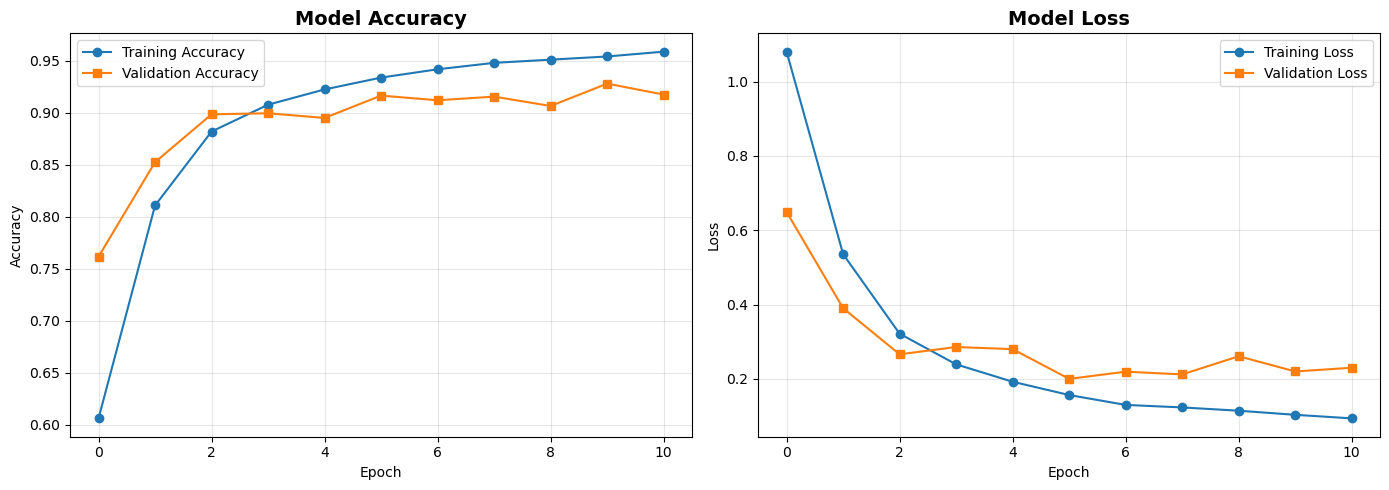


📊 Final Training Metrics:
  Training Accuracy: 0.9587
  Validation Accuracy: 0.9175
  Training Loss: 0.0934
  Validation Loss: 0.2297


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Final Training Metrics:")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")


## 📈 Evaluate Final Model Performance


In [24]:
# Evaluate on validation set
val_loss, val_accuracy = final_model.evaluate(X_val_padded, y_val, verbose=0)
print(f"\n📊 Final Model Performance:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions
y_pred = final_model.predict(X_val_padded, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)



📊 Final Model Performance:
  Validation Loss: 0.1998
  Validation Accuracy: 0.9165


## 🎯 Confusion Matrix


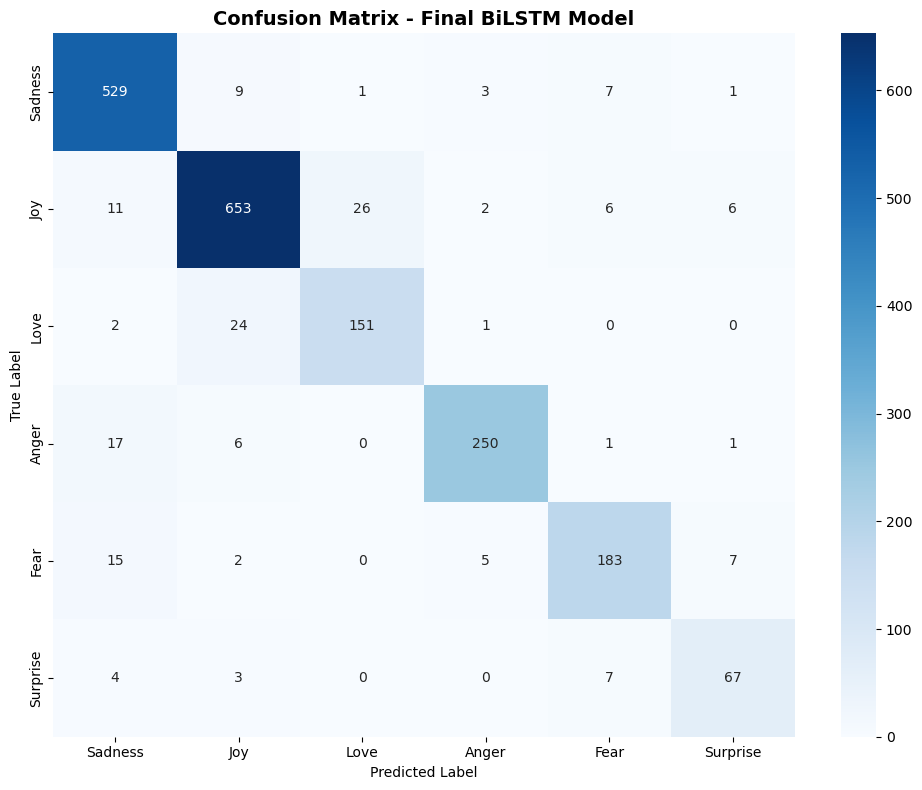

In [25]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'],
            yticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.title('Confusion Matrix - Final BiLSTM Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 📝 Classification Report


In [26]:
# Generate classification report
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
report = classification_report(y_val, y_pred_classes, target_names=emotion_labels)
print("\n📝 Classification Report:")
print("=" * 60)
print(report)



📝 Classification Report:
              precision    recall  f1-score   support

     Sadness       0.92      0.96      0.94       550
         Joy       0.94      0.93      0.93       704
        Love       0.85      0.85      0.85       178
       Anger       0.96      0.91      0.93       275
        Fear       0.90      0.86      0.88       212
    Surprise       0.82      0.83      0.82        81

    accuracy                           0.92      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.92      0.92      0.92      2000



## 💾 Save Final Model and Tokenizer

Save the final model (trained with best hyperparameters), tokenizer, and metadata.


In [27]:
import os

# Create output directory
output_dir = './data/lstm'
os.makedirs(output_dir, exist_ok=True)

# Save the final model
model_path = os.path.join(output_dir, 'lstm_model.keras')
final_model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# Save tokenizer
tokenizer_path = os.path.join(output_dir, 'lstm_tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer saved to: {tokenizer_path}")

# Save metadata including best hyperparameters
metadata = {
    'maxlen': maxlen,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'best_hyperparameters': best_hyperparameters,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'emotion_labels': emotion_labels
}

metadata_path = os.path.join(output_dir, 'lstm_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✅ Metadata saved to: {metadata_path}")

print("\n" + "=" * 60)
print("✅ All files saved successfully!")
print("=" * 60)
print(f"\nFinal Model Performance:")
print(f"  Validation Accuracy: {val_accuracy:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"\nBest Hyperparameters Used:")
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")


✅ Model saved to: ./data/lstm/lstm_model.keras
✅ Tokenizer saved to: ./data/lstm/lstm_tokenizer.pkl
✅ Metadata saved to: ./data/lstm/lstm_metadata.pkl

✅ All files saved successfully!

Final Model Performance:
  Validation Accuracy: 0.9165
  Validation Loss: 0.1998

Best Hyperparameters Used:
  learning_rate: 0.001
  batch_size: 32
  lstm_units: 192
  dropout_rate: 0.3
  dense_units: 64
  optimizer: adam
  embedding_trainable: False
